In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical, multi_gpu_model, Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
data_dir = 'data/'

In [5]:
# train_data = np.load(path.join(data_dir, 'imagenet_6_class_172_train_data.npz'))
# val_data = np.load(path.join(data_dir, 'imagenet_6_class_172_val_data.npz'))

x_train = np.load(path.join(data_dir, 'imagenet_6_class_172_x_train.npy'))
y_train = np.load(path.join(data_dir, 'imagenet_6_class_172_y_train.npy'))
x_val = np.load(path.join(data_dir, 'imagenet_6_class_172_x_val.npy'))
y_val = np.load(path.join(data_dir, 'imagenet_6_class_172_y_val.npy'))
y_list = np.load(path.join(data_dir, 'imagenet_6_class_172_y_list.npy'))

In [8]:
# x_train = train_data['x_data']
# y_train = train_data['y_data']
# x_val = val_data['x_data']
# y_val = val_data['y_data']
x_test = x_val
y_test = y_val
# y_list = val_data['y_list']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_list.shape

((235111, 172, 172, 3),
 (235111,),
 (3183, 172, 172, 3),
 (3183,),
 (3183, 172, 172, 3),
 (3183,),
 (6,))

In [10]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = y_val

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((235111, 172, 172, 3),
 (235111, 6),
 (3183, 172, 172, 3),
 (3183, 6),
 (3183, 172, 172, 3),
 (3183, 6))

In [13]:
y_list, y_train.sum(axis=0), y_val.sum(axis=0)

(array(['bed', 'bird', 'cat', 'dog', 'house', 'tree'], dtype='<U5'),
 array([  2690.,  72641.,   6500., 149006.,   1611.,   2663.],
       dtype=float32),
 array([  30., 1050.,   78., 1940.,   34.,   51.], dtype=float32))

In [8]:
input_shape = x_train[0].shape
output_size = len(y_list)

# input_shape = (172,172,3)
# output_size = 6

In [9]:
def build_2d_cnn_custom_ch_32_DO(conv_num=1):
    input_layer = Input(shape=input_shape)
    x = input_layer

    for i in range(conv_num):
        x = Conv2D(kernel_size=5, filters=32*(2**(i//2)), strides=(1,1), padding='same')(x)
#         x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D(pool_size=2, strides=(2,2), padding='same')(x)

    x = Flatten()(x)
  
    x = Dropout(0.5)(x)
    output_layer = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

In [10]:
for i in range(1, 8):
    model = build_2d_cnn_custom_ch_32_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 172, 172, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 172, 172, 32)      2432      
_________________________________________________________________
activation (Activation)      (None, 172, 172, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 86, 86, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 236672)            0         
_________________________________________________________________
dropout (Dropout)    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 172, 172, 3)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 172, 172, 32)      2432      
_________________________________________________________________
activation_21 (Activation)   (None, 172, 172, 32)      0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 86, 86, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 86, 86, 32)        25632     
_________________________________________________________________
activation_22 (Activation)   (None, 86, 86, 32)        0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 43, 43, 32)        0         
__________

In [11]:
class BalanceDataGenerator(Sequence):
    def __init__(self, x_data, y_data, batch_size, shuffle=True):
        self.x_data = x_data
        self.y_data = y_data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.sample_size = int(np.sum(y_data, axis=0).min())
        self.data_shape = x_data.shape[1:]
        self.y_label = self.y_data.argmax(axis=1)
        self.labels = np.unique(self.y_label)
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.labels) * self.sample_size / self.batch_size))

    def on_epoch_end(self):
        self.indexes = np.zeros((len(self.labels), self.sample_size))
        for i, label in enumerate(self.labels):
            y_index = np.argwhere(self.y_label==label).squeeze()
            if self.shuffle == True:
                self.indexes[i] = np.random.choice(y_index, 
                                   self.sample_size, 
                                   replace=False)
            else:
                self.indexes[i] = y_index[:self.sample_size]
                
        self.indexes = self.indexes.flatten().astype(np.int32)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
                
    def __getitem__(self, batch_idx):
        indices = self.indexes[batch_idx*self.batch_size: (batch_idx+1)*self.batch_size]
        return self.x_data[indices], self.y_data[indices]    

In [12]:
batch_size = 40
data_generator = BalanceDataGenerator(x_train, y_train,
                                      batch_size=batch_size)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10000
3200/3183 [==============================] - 11s 3ms/sample - loss: 1.7990 - acc: 0.2100

Epoch 00001: val_loss improved from inf to 1.79902, saving model to model/checkpoint/vis_imagenet_6_class_2D_CNN_custom_ch_32_DO_050_DO_5_conv_checkpoint/001-1.7990.hdf5
242/242 [==============================] - 29s 119ms/step - loss: 1.5512 - acc: 0.3388 - val_loss: 1.7990 - val_acc: 0.2100
Epoch 2/10000
3200/3183 [==============================] - 11s 3ms/sample - loss: 1.2678 - acc: 0.5225

Epoch 00002: val_loss improved from 1.79902 to 1.26777, saving model to model/checkpoint/vis_imagenet_6_class_2D_CNN_custom_ch_32_DO_050_DO_5_conv_checkpoint/002-1.2678.hdf5
242/242 [==============================] - 50s 207ms/step - loss: 1.2622 - acc: 0.4945 - val_loss: 1.2678 - val_acc: 0.5225
Epoch 3/10000
3200/3183 [==============================] - 24s 8ms/sample - loss: 1.1917 - acc: 0.5425

Epoch 00003: val_loss improved from 1.26777 to 1

3200/3183 [==============================] - 9s 3ms/sample - loss: 1.0013 - acc: 0.6022

Epoch 00014: val_loss did not improve from 0.75869
242/242 [==============================] - 28s 116ms/step - loss: 0.7351 - acc: 0.7181 - val_loss: 1.0013 - val_acc: 0.6022
Epoch 15/10000
3200/3183 [==============================] - 6s 2ms/sample - loss: 0.7767 - acc: 0.6975

Epoch 00015: val_loss did not improve from 0.75869
242/242 [==============================] - 19s 77ms/step - loss: 0.7068 - acc: 0.7286 - val_loss: 0.7767 - val_acc: 0.6975
Epoch 16/10000
3200/3183 [==============================] - 8s 3ms/sample - loss: 0.6685 - acc: 0.7738

Epoch 00016: val_loss improved from 0.75869 to 0.66854, saving model to model/checkpoint/vis_imagenet_6_class_2D_CNN_custom_ch_32_DO_050_DO_5_conv_checkpoint/016-0.6685.hdf5
242/242 [==============================] - 21s 88ms/step - loss: 0.7121 - acc: 0.7237 - val_loss: 0.6685 - val_acc: 0.7738
Epoch 17/10000
3200/3183 [==============================]

Epoch 29/10000
3200/3183 [==============================] - 8s 2ms/sample - loss: 0.6325 - acc: 0.7650

Epoch 00029: val_loss did not improve from 0.44930
242/242 [==============================] - 23s 94ms/step - loss: 0.5796 - acc: 0.7811 - val_loss: 0.6325 - val_acc: 0.7650
Epoch 30/10000
3200/3183 [==============================] - 6s 2ms/sample - loss: 0.6354 - acc: 0.7969

Epoch 00030: val_loss did not improve from 0.44930
242/242 [==============================] - 19s 79ms/step - loss: 0.5613 - acc: 0.7849 - val_loss: 0.6354 - val_acc: 0.7969
Epoch 31/10000
3200/3183 [==============================] - 8s 2ms/sample - loss: 0.6812 - acc: 0.7697 2s - loss: 0.6449 -

Epoch 00031: val_loss did not improve from 0.44930
242/242 [==============================] - 19s 80ms/step - loss: 0.5654 - acc: 0.7815 - val_loss: 0.6812 - val_acc: 0.7697
Epoch 32/10000
3200/3183 [==============================] - 7s 2ms/sample - loss: 0.4821 - acc: 0.8363

Epoch 00032: val_loss did not improve from

3200/3183 [==============================] - 12s 4ms/sample - loss: 0.7248 - acc: 0.7509

Epoch 00044: val_loss did not improve from 0.38344
242/242 [==============================] - 24s 98ms/step - loss: 0.4645 - acc: 0.8288 - val_loss: 0.7248 - val_acc: 0.7509
Epoch 45/10000
3200/3183 [==============================] - 7s 2ms/sample - loss: 0.5886 - acc: 0.7950

Epoch 00045: val_loss did not improve from 0.38344
242/242 [==============================] - 19s 80ms/step - loss: 0.4838 - acc: 0.8134 - val_loss: 0.5886 - val_acc: 0.7950
Epoch 46/10000
3200/3183 [==============================] - 6s 2ms/sample - loss: 0.5267 - acc: 0.8225

Epoch 00046: val_loss did not improve from 0.38344
242/242 [==============================] - 19s 79ms/step - loss: 0.4778 - acc: 0.8185 - val_loss: 0.5267 - val_acc: 0.8225
Epoch 47/10000
3200/3183 [==============================] - 9s 3ms/sample - loss: 0.5574 - acc: 0.8016

Epoch 00047: val_loss did not improve from 0.38344
242/242 [================

3200/3183 [==============================] - 8s 2ms/sample - loss: 0.4600 - acc: 0.8409

Epoch 00059: val_loss did not improve from 0.35206
242/242 [==============================] - 20s 81ms/step - loss: 0.4067 - acc: 0.8469 - val_loss: 0.4600 - val_acc: 0.8409
Epoch 60/10000
3200/3183 [==============================] - 7s 2ms/sample - loss: 0.7988 - acc: 0.7275

Epoch 00060: val_loss did not improve from 0.35206
242/242 [==============================] - 20s 81ms/step - loss: 0.3985 - acc: 0.8486 - val_loss: 0.7988 - val_acc: 0.7275
Epoch 61/10000
3200/3183 [==============================] - 11s 3ms/sample - loss: 0.5380 - acc: 0.8184

Epoch 00061: val_loss did not improve from 0.35206
242/242 [==============================] - 23s 94ms/step - loss: 0.4115 - acc: 0.8423 - val_loss: 0.5380 - val_acc: 0.8184
Epoch 62/10000
3200/3183 [==============================] - 6s 2ms/sample - loss: 0.3738 - acc: 0.8650

Epoch 00062: val_loss did not improve from 0.35206
242/242 [================

Epoch 75/10000
3200/3183 [==============================] - 9s 3ms/sample - loss: 0.4156 - acc: 0.8575

Epoch 00075: val_loss did not improve from 0.35206
242/242 [==============================] - 21s 88ms/step - loss: 0.3666 - acc: 0.8616 - val_loss: 0.4156 - val_acc: 0.8575
Epoch 76/10000
3200/3183 [==============================] - 6s 2ms/sample - loss: 0.4662 - acc: 0.8341

Epoch 00076: val_loss did not improve from 0.35206
242/242 [==============================] - 19s 77ms/step - loss: 0.3485 - acc: 0.8710 - val_loss: 0.4662 - val_acc: 0.8341
Epoch 77/10000
3200/3183 [==============================] - 9s 3ms/sample - loss: 0.3043 - acc: 0.9013

Epoch 00077: val_loss improved from 0.35206 to 0.30430, saving model to model/checkpoint/vis_imagenet_6_class_2D_CNN_custom_ch_32_DO_050_DO_5_conv_checkpoint/077-0.3043.hdf5
242/242 [==============================] - 20s 84ms/step - loss: 0.3505 - acc: 0.8693 - val_loss: 0.3043 - val_acc: 0.9013
Epoch 78/10000
3200/3183 [=================

3200/3183 [==============================] - 8s 2ms/sample - loss: 0.4112 - acc: 0.8616

Epoch 00090: val_loss did not improve from 0.27731
242/242 [==============================] - 20s 83ms/step - loss: 0.3218 - acc: 0.8803 - val_loss: 0.4112 - val_acc: 0.8616
Epoch 91/10000
3200/3183 [==============================] - 8s 2ms/sample - loss: 0.4330 - acc: 0.8556

Epoch 00091: val_loss did not improve from 0.27731
242/242 [==============================] - 24s 99ms/step - loss: 0.2957 - acc: 0.8897 - val_loss: 0.4330 - val_acc: 0.8556
Epoch 92/10000
3200/3183 [==============================] - 9s 3ms/sample - loss: 0.3029 - acc: 0.8919

Epoch 00092: val_loss did not improve from 0.27731
242/242 [==============================] - 20s 84ms/step - loss: 0.3078 - acc: 0.8816 - val_loss: 0.3029 - val_acc: 0.8919
Epoch 93/10000
3200/3183 [==============================] - 10s 3ms/sample - loss: 0.4327 - acc: 0.8553

Epoch 00093: val_loss did not improve from 0.27731
242/242 [================

3200/3183 [==============================] - 8s 2ms/sample - loss: 0.1898 - acc: 0.9419

Epoch 00105: val_loss improved from 0.24751 to 0.18983, saving model to model/checkpoint/vis_imagenet_6_class_2D_CNN_custom_ch_32_DO_050_DO_5_conv_checkpoint/105-0.1898.hdf5
242/242 [==============================] - 21s 87ms/step - loss: 0.2918 - acc: 0.8928 - val_loss: 0.1898 - val_acc: 0.9419
Epoch 106/10000
3200/3183 [==============================] - 9s 3ms/sample - loss: 0.3763 - acc: 0.8850 2s - loss: 0.3521 - 

Epoch 00106: val_loss did not improve from 0.18983
242/242 [==============================] - 22s 90ms/step - loss: 0.2779 - acc: 0.8911 - val_loss: 0.3763 - val_acc: 0.8850
Epoch 107/10000
3200/3183 [==============================] - 9s 3ms/sample - loss: 0.3893 - acc: 0.8619

Epoch 00107: val_loss did not improve from 0.18983
242/242 [==============================] - 21s 86ms/step - loss: 0.2705 - acc: 0.9010 - val_loss: 0.3893 - val_acc: 0.8619
Epoch 108/10000
3200/3183 [========

Epoch 120/10000
3200/3183 [==============================] - 8s 2ms/sample - loss: 0.3585 - acc: 0.8775

Epoch 00120: val_loss did not improve from 0.18983
242/242 [==============================] - 20s 84ms/step - loss: 0.2703 - acc: 0.9000 - val_loss: 0.3585 - val_acc: 0.8775
Epoch 121/10000
3200/3183 [==============================] - 9s 3ms/sample - loss: 0.3989 - acc: 0.8634

Epoch 00121: val_loss did not improve from 0.18983
242/242 [==============================] - 34s 141ms/step - loss: 0.2647 - acc: 0.9002 - val_loss: 0.3989 - val_acc: 0.8634
Epoch 122/10000
3200/3183 [==============================] - 9s 3ms/sample - loss: 0.3764 - acc: 0.8741

Epoch 00122: val_loss did not improve from 0.18983
242/242 [==============================] - 22s 90ms/step - loss: 0.2547 - acc: 0.9063 - val_loss: 0.3764 - val_acc: 0.8741
Epoch 123/10000
3200/3183 [==============================] - 9s 3ms/sample - loss: 0.3073 - acc: 0.8916

Epoch 00123: val_loss did not improve from 0.18983
242/24

3200/3183 [==============================] - 9s 3ms/sample - loss: 0.2733 - acc: 0.9100

Epoch 00135: val_loss did not improve from 0.18983
242/242 [==============================] - 28s 116ms/step - loss: 0.2523 - acc: 0.9073 - val_loss: 0.2733 - val_acc: 0.9100
Epoch 136/10000
3200/3183 [==============================] - 8s 3ms/sample - loss: 0.2757 - acc: 0.9025

Epoch 00136: val_loss did not improve from 0.18983
242/242 [==============================] - 25s 105ms/step - loss: 0.2464 - acc: 0.9098 - val_loss: 0.2757 - val_acc: 0.9025
Epoch 137/10000
3200/3183 [==============================] - 8s 3ms/sample - loss: 0.2740 - acc: 0.9053

Epoch 00137: val_loss did not improve from 0.18983
242/242 [==============================] - 25s 103ms/step - loss: 0.2305 - acc: 0.9143 - val_loss: 0.2740 - val_acc: 0.9053
Epoch 138/10000
3200/3183 [==============================] - 8s 3ms/sample - loss: 0.2211 - acc: 0.9212

Epoch 00138: val_loss did not improve from 0.18983
242/242 [===========

Epoch 151/10000
3200/3183 [==============================] - 10s 3ms/sample - loss: 0.5081 - acc: 0.8313

Epoch 00151: val_loss did not improve from 0.18983
242/242 [==============================] - 22s 90ms/step - loss: 0.2287 - acc: 0.9172 - val_loss: 0.5081 - val_acc: 0.8313
Epoch 152/10000
3200/3183 [==============================] - 10s 3ms/sample - loss: 0.2907 - acc: 0.8841

Epoch 00152: val_loss did not improve from 0.18983
242/242 [==============================] - 32s 131ms/step - loss: 0.2291 - acc: 0.9138 - val_loss: 0.2907 - val_acc: 0.8841
Epoch 153/10000
3200/3183 [==============================] - 10s 3ms/sample - loss: 0.3509 - acc: 0.8772

Epoch 00153: val_loss did not improve from 0.18983
242/242 [==============================] - 36s 148ms/step - loss: 0.2170 - acc: 0.9201 - val_loss: 0.3509 - val_acc: 0.8772
Epoch 154/10000
3200/3183 [==============================] - 12s 4ms/sample - loss: 0.3886 - acc: 0.8550

Epoch 00154: val_loss did not improve from 0.18983
2

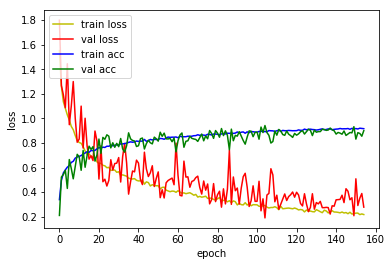

3183/3183 [==============================] - 3s 936us/sample - loss: 0.4856 - acc: 0.8014
Loss: 0.48557202282975837 Accuracy: 0.8014452

Epoch 1/10000
3200/3183 [==============================] - 11s 3ms/sample - loss: 1.3299 - acc: 0.5069

Epoch 00001: val_loss improved from inf to 1.32989, saving model to model/checkpoint/vis_imagenet_6_class_2D_CNN_custom_ch_32_DO_050_DO_6_conv_checkpoint/001-1.3299.hdf5
242/242 [==============================] - 23s 96ms/step - loss: 1.5169 - acc: 0.3589 - val_loss: 1.3299 - val_acc: 0.5069
Epoch 2/10000
3200/3183 [==============================] - 8s 2ms/sample - loss: 1.4597 - acc: 0.3800

Epoch 00002: val_loss did not improve from 1.32989
242/242 [==============================] - 21s 85ms/step - loss: 1.2700 - acc: 0.4888 - val_loss: 1.4597 - val_acc: 0.3800
Epoch 3/10000
3200/3183 [==============================] - 11s 3ms/sample - loss: 0.9946 - acc: 0.7075

Epoch 00003: val_loss improved from 1.32989 to 0.99458, saving model to model/checkpo

3200/3183 [==============================] - 9s 3ms/sample - loss: 0.7104 - acc: 0.7306

Epoch 00015: val_loss did not improve from 0.55909
242/242 [==============================] - 27s 110ms/step - loss: 0.6783 - acc: 0.7309 - val_loss: 0.7104 - val_acc: 0.7306
Epoch 16/10000
3200/3183 [==============================] - 9s 3ms/sample - loss: 0.9111 - acc: 0.6500

Epoch 00016: val_loss did not improve from 0.55909
242/242 [==============================] - 22s 92ms/step - loss: 0.6494 - acc: 0.7450 - val_loss: 0.9111 - val_acc: 0.6500
Epoch 17/10000
3200/3183 [==============================] - 11s 3ms/sample - loss: 0.7860 - acc: 0.6875

Epoch 00017: val_loss did not improve from 0.55909
242/242 [==============================] - 24s 97ms/step - loss: 0.6466 - acc: 0.7514 - val_loss: 0.7860 - val_acc: 0.6875
Epoch 18/10000
3200/3183 [==============================] - 9s 3ms/sample - loss: 0.6881 - acc: 0.7519

Epoch 00018: val_loss did not improve from 0.55909
242/242 [===============

3200/3183 [==============================] - 8s 3ms/sample - loss: 0.5500 - acc: 0.8025

Epoch 00030: val_loss did not improve from 0.50119
242/242 [==============================] - 24s 100ms/step - loss: 0.5004 - acc: 0.8112 - val_loss: 0.5500 - val_acc: 0.8025
Epoch 31/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.5523 - acc: 0.8000

Epoch 00031: val_loss did not improve from 0.50119
242/242 [==============================] - 34s 140ms/step - loss: 0.5153 - acc: 0.8024 - val_loss: 0.5523 - val_acc: 0.8000
Epoch 32/10000
3200/3183 [==============================] - 10s 3ms/sample - loss: 0.5270 - acc: 0.8050

Epoch 00032: val_loss did not improve from 0.50119
242/242 [==============================] - 24s 100ms/step - loss: 0.4836 - acc: 0.8124 - val_loss: 0.5270 - val_acc: 0.8050
Epoch 33/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.5328 - acc: 0.8209

Epoch 00033: val_loss did not improve from 0.50119
242/242 [===========

Epoch 45/10000
3200/3183 [==============================] - 10s 3ms/sample - loss: 0.5506 - acc: 0.7875

Epoch 00045: val_loss did not improve from 0.39453
242/242 [==============================] - 27s 112ms/step - loss: 0.4109 - acc: 0.8424 - val_loss: 0.5506 - val_acc: 0.7875
Epoch 46/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 0.3548 - acc: 0.8675

Epoch 00046: val_loss improved from 0.39453 to 0.35477, saving model to model/checkpoint/vis_imagenet_6_class_2D_CNN_custom_ch_32_DO_050_DO_6_conv_checkpoint/046-0.3548.hdf5
242/242 [==============================] - 36s 147ms/step - loss: 0.3913 - acc: 0.8492 - val_loss: 0.3548 - val_acc: 0.8675
Epoch 47/10000
3200/3183 [==============================] - 13s 4ms/sample - loss: 0.4668 - acc: 0.8250

Epoch 00047: val_loss did not improve from 0.35477
242/242 [==============================] - 27s 110ms/step - loss: 0.3913 - acc: 0.8470 - val_loss: 0.4668 - val_acc: 0.8250
Epoch 48/10000
3200/3183 [===========

Epoch 60/10000
3200/3183 [==============================] - 15s 5ms/sample - loss: 0.5479 - acc: 0.7825

Epoch 00060: val_loss did not improve from 0.31076
242/242 [==============================] - 37s 154ms/step - loss: 0.3346 - acc: 0.8707 - val_loss: 0.5479 - val_acc: 0.7825
Epoch 61/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 0.4301 - acc: 0.8356

Epoch 00061: val_loss did not improve from 0.31076
242/242 [==============================] - 30s 123ms/step - loss: 0.3182 - acc: 0.8793 - val_loss: 0.4301 - val_acc: 0.8356
Epoch 62/10000
3200/3183 [==============================] - 9s 3ms/sample - loss: 0.5045 - acc: 0.7900

Epoch 00062: val_loss did not improve from 0.31076
242/242 [==============================] - 29s 122ms/step - loss: 0.3195 - acc: 0.8834 - val_loss: 0.5045 - val_acc: 0.7900
Epoch 63/10000
3200/3183 [==============================] - 14s 4ms/sample - loss: 0.3787 - acc: 0.8781

Epoch 00063: val_loss did not improve from 0.31076
242/2

3200/3183 [==============================] - 10s 3ms/sample - loss: 0.4254 - acc: 0.8300

Epoch 00075: val_loss did not improve from 0.27506
242/242 [==============================] - 26s 109ms/step - loss: 0.2836 - acc: 0.8949 - val_loss: 0.4254 - val_acc: 0.8300
Epoch 76/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.3564 - acc: 0.8650

Epoch 00076: val_loss did not improve from 0.27506
242/242 [==============================] - 35s 146ms/step - loss: 0.2764 - acc: 0.8922 - val_loss: 0.3564 - val_acc: 0.8650
Epoch 77/10000
3200/3183 [==============================] - 13s 4ms/sample - loss: 0.3079 - acc: 0.8913

Epoch 00077: val_loss did not improve from 0.27506
242/242 [==============================] - 26s 109ms/step - loss: 0.2833 - acc: 0.8970 - val_loss: 0.3079 - val_acc: 0.8913
Epoch 78/10000
3200/3183 [==============================] - 11s 4ms/sample - loss: 0.4163 - acc: 0.8500

Epoch 00078: val_loss did not improve from 0.27506
242/242 [==========

3200/3183 [==============================] - 15s 5ms/sample - loss: 0.3560 - acc: 0.8706

Epoch 00090: val_loss did not improve from 0.25149
242/242 [==============================] - 39s 161ms/step - loss: 0.2450 - acc: 0.9114 - val_loss: 0.3560 - val_acc: 0.8706
Epoch 91/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.4419 - acc: 0.8400

Epoch 00091: val_loss did not improve from 0.25149
242/242 [==============================] - 38s 158ms/step - loss: 0.2408 - acc: 0.9112 - val_loss: 0.4419 - val_acc: 0.8400
Epoch 92/10000
3200/3183 [==============================] - 18s 5ms/sample - loss: 0.2632 - acc: 0.9125

Epoch 00092: val_loss did not improve from 0.25149
242/242 [==============================] - 42s 174ms/step - loss: 0.2385 - acc: 0.9112 - val_loss: 0.2632 - val_acc: 0.9125
Epoch 93/10000
3200/3183 [==============================] - 8s 3ms/sample - loss: 0.3869 - acc: 0.8600

Epoch 00093: val_loss did not improve from 0.25149
242/242 [===========

242/242 [==============================] - 37s 155ms/step - loss: 0.2163 - acc: 0.9233 - val_loss: 0.2443 - val_acc: 0.9050
Epoch 106/10000
3200/3183 [==============================] - 10s 3ms/sample - loss: 0.4534 - acc: 0.8206

Epoch 00106: val_loss did not improve from 0.24425
242/242 [==============================] - 26s 106ms/step - loss: 0.2124 - acc: 0.9223 - val_loss: 0.4534 - val_acc: 0.8206
Epoch 107/10000
3200/3183 [==============================] - 10s 3ms/sample - loss: 0.2572 - acc: 0.9150

Epoch 00107: val_loss did not improve from 0.24425
242/242 [==============================] - 30s 122ms/step - loss: 0.2071 - acc: 0.9223 - val_loss: 0.2572 - val_acc: 0.9150
Epoch 108/10000
3200/3183 [==============================] - 9s 3ms/sample - loss: 0.3866 - acc: 0.8547

Epoch 00108: val_loss did not improve from 0.24425
242/242 [==============================] - 26s 108ms/step - loss: 0.2056 - acc: 0.9246 - val_loss: 0.3866 - val_acc: 0.8547
Epoch 109/10000
3200/3183 [=======

Epoch 121/10000
3200/3183 [==============================] - 13s 4ms/sample - loss: 0.4049 - acc: 0.8600

Epoch 00121: val_loss did not improve from 0.20251
242/242 [==============================] - 30s 125ms/step - loss: 0.1843 - acc: 0.9340 - val_loss: 0.4049 - val_acc: 0.8600
Epoch 122/10000
3200/3183 [==============================] - 11s 4ms/sample - loss: 0.3209 - acc: 0.8841

Epoch 00122: val_loss did not improve from 0.20251
242/242 [==============================] - 35s 146ms/step - loss: 0.1826 - acc: 0.9331 - val_loss: 0.3209 - val_acc: 0.8841
Epoch 123/10000
3200/3183 [==============================] - 12s 4ms/sample - loss: 0.3392 - acc: 0.8725

Epoch 00123: val_loss did not improve from 0.20251
242/242 [==============================] - 37s 152ms/step - loss: 0.1954 - acc: 0.9291 - val_loss: 0.3392 - val_acc: 0.8725
Epoch 124/10000
3200/3183 [==============================] - 10s 3ms/sample - loss: 0.3640 - acc: 0.8753

Epoch 00124: val_loss did not improve from 0.20251


3200/3183 [==============================] - 11s 3ms/sample - loss: 0.3085 - acc: 0.8900

Epoch 00136: val_loss did not improve from 0.20251
242/242 [==============================] - 41s 170ms/step - loss: 0.1779 - acc: 0.9380 - val_loss: 0.3085 - val_acc: 0.8900
Epoch 137/10000
3200/3183 [==============================] - 10s 3ms/sample - loss: 0.2925 - acc: 0.8950

Epoch 00137: val_loss did not improve from 0.20251
242/242 [==============================] - 32s 132ms/step - loss: 0.1653 - acc: 0.9430 - val_loss: 0.2925 - val_acc: 0.8950
Epoch 138/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.3588 - acc: 0.8697

Epoch 00138: val_loss did not improve from 0.20251
242/242 [==============================] - 46s 192ms/step - loss: 0.1747 - acc: 0.9366 - val_loss: 0.3588 - val_acc: 0.8697
Epoch 139/10000
3200/3183 [==============================] - 11s 3ms/sample - loss: 0.3130 - acc: 0.8956

Epoch 00139: val_loss did not improve from 0.20251
242/242 [=======

Epoch 152/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.2043 - acc: 0.9337

Epoch 00152: val_loss did not improve from 0.19393
242/242 [==============================] - 37s 152ms/step - loss: 0.1608 - acc: 0.9415 - val_loss: 0.2043 - val_acc: 0.9337
Epoch 153/10000
3200/3183 [==============================] - 11s 3ms/sample - loss: 0.3836 - acc: 0.8750

Epoch 00153: val_loss did not improve from 0.19393
242/242 [==============================] - 25s 105ms/step - loss: 0.1473 - acc: 0.9479 - val_loss: 0.3836 - val_acc: 0.8750
Epoch 154/10000
3200/3183 [==============================] - 21s 7ms/sample - loss: 0.2748 - acc: 0.8959

Epoch 00154: val_loss did not improve from 0.19393
242/242 [==============================] - 41s 169ms/step - loss: 0.1544 - acc: 0.9410 - val_loss: 0.2748 - val_acc: 0.8959
Epoch 155/10000
3200/3183 [==============================] - 10s 3ms/sample - loss: 0.3214 - acc: 0.8728

Epoch 00155: val_loss did not improve from 0.19393


3200/3183 [==============================] - 15s 5ms/sample - loss: 0.2061 - acc: 0.9275

Epoch 00167: val_loss did not improve from 0.18162
242/242 [==============================] - 30s 125ms/step - loss: 0.1427 - acc: 0.9497 - val_loss: 0.2061 - val_acc: 0.9275
Epoch 168/10000
3200/3183 [==============================] - 13s 4ms/sample - loss: 0.2629 - acc: 0.8938

Epoch 00168: val_loss did not improve from 0.18162
242/242 [==============================] - 30s 122ms/step - loss: 0.1470 - acc: 0.9475 - val_loss: 0.2629 - val_acc: 0.8938
Epoch 169/10000
3200/3183 [==============================] - 13s 4ms/sample - loss: 0.3284 - acc: 0.8775

Epoch 00169: val_loss did not improve from 0.18162
242/242 [==============================] - 37s 152ms/step - loss: 0.1484 - acc: 0.9486 - val_loss: 0.3284 - val_acc: 0.8775
Epoch 170/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.2990 - acc: 0.9000

Epoch 00170: val_loss did not improve from 0.18162
242/242 [=======

3200/3183 [==============================] - 13s 4ms/sample - loss: 0.3213 - acc: 0.8950

Epoch 00182: val_loss did not improve from 0.18162
242/242 [==============================] - 37s 151ms/step - loss: 0.1329 - acc: 0.9529 - val_loss: 0.3213 - val_acc: 0.8950
Epoch 183/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.1990 - acc: 0.9256

Epoch 00183: val_loss did not improve from 0.18162
242/242 [==============================] - 46s 188ms/step - loss: 0.1258 - acc: 0.9541 - val_loss: 0.1990 - val_acc: 0.9256
Epoch 184/10000
3200/3183 [==============================] - 12s 4ms/sample - loss: 0.2094 - acc: 0.9237

Epoch 00184: val_loss did not improve from 0.18162
242/242 [==============================] - 34s 141ms/step - loss: 0.1369 - acc: 0.9514 - val_loss: 0.2094 - val_acc: 0.9237
Epoch 185/10000
3200/3183 [==============================] - 12s 4ms/sample - loss: 0.2758 - acc: 0.9075

Epoch 00185: val_loss did not improve from 0.18162
242/242 [=======

Epoch 198/10000
3200/3183 [==============================] - 13s 4ms/sample - loss: 0.2496 - acc: 0.8950

Epoch 00198: val_loss did not improve from 0.17580
242/242 [==============================] - 52s 216ms/step - loss: 0.1155 - acc: 0.9567 - val_loss: 0.2496 - val_acc: 0.8950
Epoch 199/10000
3200/3183 [==============================] - 29s 9ms/sample - loss: 0.2386 - acc: 0.8997

Epoch 00199: val_loss did not improve from 0.17580
242/242 [==============================] - 57s 238ms/step - loss: 0.1286 - acc: 0.9530 - val_loss: 0.2386 - val_acc: 0.8997
Epoch 200/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.1831 - acc: 0.9350

Epoch 00200: val_loss did not improve from 0.17580
242/242 [==============================] - 60s 246ms/step - loss: 0.1199 - acc: 0.9576 - val_loss: 0.1831 - val_acc: 0.9350
Epoch 201/10000
3200/3183 [==============================] - 20s 6ms/sample - loss: 0.2470 - acc: 0.9200

Epoch 00201: val_loss did not improve from 0.17580


3200/3183 [==============================] - 15s 5ms/sample - loss: 0.1863 - acc: 0.9375

Epoch 00213: val_loss did not improve from 0.17580
242/242 [==============================] - 67s 278ms/step - loss: 0.1178 - acc: 0.9594 - val_loss: 0.1863 - val_acc: 0.9375
Epoch 214/10000
3200/3183 [==============================] - 11s 3ms/sample - loss: 0.3423 - acc: 0.8763

Epoch 00214: val_loss did not improve from 0.17580
242/242 [==============================] - 34s 140ms/step - loss: 0.1138 - acc: 0.9595 - val_loss: 0.3423 - val_acc: 0.8763
Epoch 215/10000
3200/3183 [==============================] - 13s 4ms/sample - loss: 0.3761 - acc: 0.8863

Epoch 00215: val_loss did not improve from 0.17580
242/242 [==============================] - 48s 200ms/step - loss: 0.1132 - acc: 0.9579 - val_loss: 0.3761 - val_acc: 0.8863
Epoch 216/10000
3200/3183 [==============================] - 11s 3ms/sample - loss: 0.3656 - acc: 0.8694

Epoch 00216: val_loss did not improve from 0.17580
242/242 [=======

Epoch 229/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.2625 - acc: 0.9125

Epoch 00229: val_loss did not improve from 0.17580
242/242 [==============================] - 41s 168ms/step - loss: 0.1070 - acc: 0.9617 - val_loss: 0.2625 - val_acc: 0.9125
Epoch 230/10000
3200/3183 [==============================] - 13s 4ms/sample - loss: 0.2405 - acc: 0.9262

Epoch 00230: val_loss did not improve from 0.17580
242/242 [==============================] - 27s 112ms/step - loss: 0.1046 - acc: 0.9611 - val_loss: 0.2405 - val_acc: 0.9262
Epoch 231/10000
3200/3183 [==============================] - 21s 7ms/sample - loss: 0.3843 - acc: 0.8900

Epoch 00231: val_loss did not improve from 0.17580
242/242 [==============================] - 40s 164ms/step - loss: 0.0989 - acc: 0.9630 - val_loss: 0.3843 - val_acc: 0.8900
Epoch 232/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 0.2290 - acc: 0.9181

Epoch 00232: val_loss did not improve from 0.17580


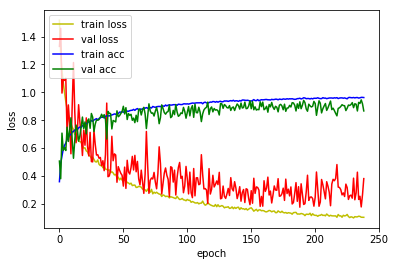

3183/3183 [==============================] - 3s 1ms/sample - loss: 0.2597 - acc: 0.9045
Loss: 0.259689773843418 Accuracy: 0.9044926

Epoch 1/10000
3200/3183 [==============================] - 12s 4ms/sample - loss: 1.5979 - acc: 0.3091

Epoch 00001: val_loss improved from inf to 1.59791, saving model to model/checkpoint/vis_imagenet_6_class_2D_CNN_custom_ch_32_DO_050_DO_7_conv_checkpoint/001-1.5979.hdf5
242/242 [==============================] - 28s 116ms/step - loss: 1.5178 - acc: 0.3479 - val_loss: 1.5979 - val_acc: 0.3091
Epoch 2/10000
3200/3183 [==============================] - 24s 8ms/sample - loss: 1.4420 - acc: 0.3875

Epoch 00002: val_loss improved from 1.59791 to 1.44195, saving model to model/checkpoint/vis_imagenet_6_class_2D_CNN_custom_ch_32_DO_050_DO_7_conv_checkpoint/002-1.4420.hdf5
242/242 [==============================] - 57s 236ms/step - loss: 1.2807 - acc: 0.4786 - val_loss: 1.4420 - val_acc: 0.3875
Epoch 3/10000
3200/3183 [==============================] - 11s 3ms/

242/242 [==============================] - 27s 112ms/step - loss: 0.6451 - acc: 0.7490 - val_loss: 0.5057 - val_acc: 0.8234
Epoch 15/10000
3200/3183 [==============================] - 11s 4ms/sample - loss: 0.6472 - acc: 0.7681

Epoch 00015: val_loss did not improve from 0.50569
242/242 [==============================] - 66s 273ms/step - loss: 0.6250 - acc: 0.7594 - val_loss: 0.6472 - val_acc: 0.7681
Epoch 16/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 0.8179 - acc: 0.7078

Epoch 00016: val_loss did not improve from 0.50569
242/242 [==============================] - 31s 130ms/step - loss: 0.5927 - acc: 0.7685 - val_loss: 0.8179 - val_acc: 0.7078
Epoch 17/10000
3200/3183 [==============================] - 10s 3ms/sample - loss: 0.6359 - acc: 0.7797

Epoch 00017: val_loss did not improve from 0.50569
242/242 [==============================] - 76s 314ms/step - loss: 0.5857 - acc: 0.7712 - val_loss: 0.6359 - val_acc: 0.7797
Epoch 18/10000
3200/3183 [==========

Epoch 30/10000
3200/3183 [==============================] - 10s 3ms/sample - loss: 0.5972 - acc: 0.7675

Epoch 00030: val_loss did not improve from 0.50227
242/242 [==============================] - 63s 259ms/step - loss: 0.4295 - acc: 0.8376 - val_loss: 0.5972 - val_acc: 0.7675
Epoch 31/10000
3200/3183 [==============================] - 12s 4ms/sample - loss: 0.6592 - acc: 0.7487

Epoch 00031: val_loss did not improve from 0.50227
242/242 [==============================] - 41s 168ms/step - loss: 0.4126 - acc: 0.8387 - val_loss: 0.6592 - val_acc: 0.7487
Epoch 32/10000
3200/3183 [==============================] - 10s 3ms/sample - loss: 0.4243 - acc: 0.8506

Epoch 00032: val_loss improved from 0.50227 to 0.42425, saving model to model/checkpoint/vis_imagenet_6_class_2D_CNN_custom_ch_32_DO_050_DO_7_conv_checkpoint/032-0.4243.hdf5
242/242 [==============================] - 55s 229ms/step - loss: 0.3994 - acc: 0.8432 - val_loss: 0.4243 - val_acc: 0.8506
Epoch 33/10000
3200/3183 [===========

3200/3183 [==============================] - 8s 3ms/sample - loss: 0.5603 - acc: 0.8125

Epoch 00044: val_loss did not improve from 0.23675
242/242 [==============================] - 37s 154ms/step - loss: 0.3204 - acc: 0.8773 - val_loss: 0.5603 - val_acc: 0.8125
Epoch 45/10000
3200/3183 [==============================] - 10s 3ms/sample - loss: 0.5304 - acc: 0.8200

Epoch 00045: val_loss did not improve from 0.23675
242/242 [==============================] - 37s 152ms/step - loss: 0.3237 - acc: 0.8725 - val_loss: 0.5304 - val_acc: 0.8200
Epoch 46/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 0.3664 - acc: 0.8675

Epoch 00046: val_loss did not improve from 0.23675
242/242 [==============================] - 34s 139ms/step - loss: 0.3088 - acc: 0.8780 - val_loss: 0.3664 - val_acc: 0.8675
Epoch 47/10000
3200/3183 [==============================] - 14s 4ms/sample - loss: 0.4289 - acc: 0.8525

Epoch 00047: val_loss did not improve from 0.23675
242/242 [===========

Epoch 60/10000
3200/3183 [==============================] - 14s 4ms/sample - loss: 0.3773 - acc: 0.8575

Epoch 00060: val_loss did not improve from 0.23675
242/242 [==============================] - 48s 200ms/step - loss: 0.2482 - acc: 0.9036 - val_loss: 0.3773 - val_acc: 0.8575
Epoch 61/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.5190 - acc: 0.8075

Epoch 00061: val_loss did not improve from 0.23675
242/242 [==============================] - 34s 140ms/step - loss: 0.2332 - acc: 0.9127 - val_loss: 0.5190 - val_acc: 0.8075
Epoch 62/10000
3200/3183 [==============================] - 13s 4ms/sample - loss: 0.4540 - acc: 0.8388

Epoch 00062: val_loss did not improve from 0.23675
242/242 [==============================] - 41s 170ms/step - loss: 0.2509 - acc: 0.9061 - val_loss: 0.4540 - val_acc: 0.8388
Epoch 63/10000
3200/3183 [==============================] - 13s 4ms/sample - loss: 0.2534 - acc: 0.9081

Epoch 00063: val_loss did not improve from 0.23675
242/

3200/3183 [==============================] - 7s 2ms/sample - loss: 0.2723 - acc: 0.8875

Epoch 00075: val_loss did not improve from 0.22462
242/242 [==============================] - 25s 102ms/step - loss: 0.1854 - acc: 0.9325 - val_loss: 0.2723 - val_acc: 0.8875
Epoch 76/10000
3200/3183 [==============================] - 11s 3ms/sample - loss: 0.2108 - acc: 0.9194

Epoch 00076: val_loss improved from 0.22462 to 0.21082, saving model to model/checkpoint/vis_imagenet_6_class_2D_CNN_custom_ch_32_DO_050_DO_7_conv_checkpoint/076-0.2108.hdf5
242/242 [==============================] - 27s 114ms/step - loss: 0.1855 - acc: 0.9304 - val_loss: 0.2108 - val_acc: 0.9194
Epoch 77/10000
3200/3183 [==============================] - 15s 5ms/sample - loss: 0.3068 - acc: 0.8850

Epoch 00077: val_loss did not improve from 0.21082
242/242 [==============================] - 30s 126ms/step - loss: 0.1979 - acc: 0.9277 - val_loss: 0.3068 - val_acc: 0.8850
Epoch 78/10000
3200/3183 [===========================

3200/3183 [==============================] - 11s 3ms/sample - loss: 0.3255 - acc: 0.8894

Epoch 00090: val_loss did not improve from 0.16872
242/242 [==============================] - 39s 160ms/step - loss: 0.1590 - acc: 0.9433 - val_loss: 0.3255 - val_acc: 0.8894
Epoch 91/10000
3200/3183 [==============================] - 21s 7ms/sample - loss: 0.2622 - acc: 0.9025

Epoch 00091: val_loss did not improve from 0.16872
242/242 [==============================] - 50s 206ms/step - loss: 0.1673 - acc: 0.9385 - val_loss: 0.2622 - val_acc: 0.9025
Epoch 92/10000
3200/3183 [==============================] - 11s 3ms/sample - loss: 0.2755 - acc: 0.9050

Epoch 00092: val_loss did not improve from 0.16872
242/242 [==============================] - 39s 162ms/step - loss: 0.1602 - acc: 0.9400 - val_loss: 0.2755 - val_acc: 0.9050
Epoch 93/10000
3200/3183 [==============================] - 13s 4ms/sample - loss: 0.4823 - acc: 0.8050

Epoch 00093: val_loss did not improve from 0.16872
242/242 [==========

3200/3183 [==============================] - 16s 5ms/sample - loss: 0.1964 - acc: 0.9275

Epoch 00105: val_loss did not improve from 0.16872
242/242 [==============================] - 43s 180ms/step - loss: 0.1376 - acc: 0.9511 - val_loss: 0.1964 - val_acc: 0.9275
Epoch 106/10000
3200/3183 [==============================] - 14s 4ms/sample - loss: 0.4042 - acc: 0.8384

Epoch 00106: val_loss did not improve from 0.16872
242/242 [==============================] - 42s 172ms/step - loss: 0.1400 - acc: 0.9512 - val_loss: 0.4042 - val_acc: 0.8384
Epoch 107/10000
3200/3183 [==============================] - 11s 3ms/sample - loss: 0.2800 - acc: 0.8944

Epoch 00107: val_loss did not improve from 0.16872
242/242 [==============================] - 39s 160ms/step - loss: 0.1441 - acc: 0.9502 - val_loss: 0.2800 - val_acc: 0.8944
Epoch 108/10000
3200/3183 [==============================] - 23s 7ms/sample - loss: 0.2125 - acc: 0.9150

Epoch 00108: val_loss did not improve from 0.16872
242/242 [=======

Epoch 121/10000
3200/3183 [==============================] - 11s 3ms/sample - loss: 0.3383 - acc: 0.8750

Epoch 00121: val_loss did not improve from 0.16872
242/242 [==============================] - 40s 166ms/step - loss: 0.1219 - acc: 0.9540 - val_loss: 0.3383 - val_acc: 0.8750
Epoch 122/10000
3200/3183 [==============================] - 22s 7ms/sample - loss: 0.2701 - acc: 0.9050

Epoch 00122: val_loss did not improve from 0.16872
242/242 [==============================] - 50s 209ms/step - loss: 0.1186 - acc: 0.9571 - val_loss: 0.2701 - val_acc: 0.9050
Epoch 123/10000
3200/3183 [==============================] - 12s 4ms/sample - loss: 0.1824 - acc: 0.9362

Epoch 00123: val_loss did not improve from 0.16872
242/242 [==============================] - 41s 169ms/step - loss: 0.1108 - acc: 0.9584 - val_loss: 0.1824 - val_acc: 0.9362
Epoch 124/10000
3200/3183 [==============================] - 14s 4ms/sample - loss: 0.2490 - acc: 0.9225

Epoch 00124: val_loss did not improve from 0.16872


3200/3183 [==============================] - 15s 5ms/sample - loss: 0.2164 - acc: 0.9250

Epoch 00136: val_loss did not improve from 0.16438
242/242 [==============================] - 33s 137ms/step - loss: 0.1137 - acc: 0.9594 - val_loss: 0.2164 - val_acc: 0.9250
Epoch 137/10000
3200/3183 [==============================] - 10s 3ms/sample - loss: 0.2601 - acc: 0.9144

Epoch 00137: val_loss did not improve from 0.16438
242/242 [==============================] - 27s 111ms/step - loss: 0.1084 - acc: 0.9640 - val_loss: 0.2601 - val_acc: 0.9144
Epoch 138/10000
3200/3183 [==============================] - 10s 3ms/sample - loss: 0.1500 - acc: 0.9525

Epoch 00138: val_loss improved from 0.16438 to 0.15004, saving model to model/checkpoint/vis_imagenet_6_class_2D_CNN_custom_ch_32_DO_050_DO_7_conv_checkpoint/138-0.1500.hdf5
242/242 [==============================] - 39s 159ms/step - loss: 0.1019 - acc: 0.9623 - val_loss: 0.1500 - val_acc: 0.9525
Epoch 139/10000
3200/3183 [=======================

3200/3183 [==============================] - 11s 3ms/sample - loss: 0.2298 - acc: 0.9125

Epoch 00151: val_loss did not improve from 0.15004
242/242 [==============================] - 39s 161ms/step - loss: 0.1004 - acc: 0.9629 - val_loss: 0.2298 - val_acc: 0.9125
Epoch 152/10000
3200/3183 [==============================] - 14s 4ms/sample - loss: 0.3285 - acc: 0.8700

Epoch 00152: val_loss did not improve from 0.15004
242/242 [==============================] - 33s 138ms/step - loss: 0.0969 - acc: 0.9651 - val_loss: 0.3285 - val_acc: 0.8700
Epoch 153/10000
3200/3183 [==============================] - 11s 3ms/sample - loss: 0.2419 - acc: 0.9200

Epoch 00153: val_loss did not improve from 0.15004
242/242 [==============================] - 62s 258ms/step - loss: 0.0978 - acc: 0.9621 - val_loss: 0.2419 - val_acc: 0.9200
Epoch 154/10000
3200/3183 [==============================] - 10s 3ms/sample - loss: 0.3551 - acc: 0.8775

Epoch 00154: val_loss did not improve from 0.15004
242/242 [=======

Epoch 167/10000
3200/3183 [==============================] - 15s 5ms/sample - loss: 0.2314 - acc: 0.9250

Epoch 00167: val_loss did not improve from 0.15004
242/242 [==============================] - 29s 119ms/step - loss: 0.0862 - acc: 0.9693 - val_loss: 0.2314 - val_acc: 0.9250
Epoch 168/10000
3200/3183 [==============================] - 14s 4ms/sample - loss: 0.3763 - acc: 0.8700

Epoch 00168: val_loss did not improve from 0.15004
242/242 [==============================] - 30s 124ms/step - loss: 0.0898 - acc: 0.9678 - val_loss: 0.3763 - val_acc: 0.8700
Epoch 169/10000
3200/3183 [==============================] - 15s 5ms/sample - loss: 0.2082 - acc: 0.9400

Epoch 00169: val_loss did not improve from 0.15004
242/242 [==============================] - 43s 179ms/step - loss: 0.0866 - acc: 0.9671 - val_loss: 0.2082 - val_acc: 0.9400
Epoch 170/10000
3200/3183 [==============================] - 12s 4ms/sample - loss: 0.3150 - acc: 0.8856

Epoch 00170: val_loss did not improve from 0.15004


3200/3183 [==============================] - 23s 7ms/sample - loss: 0.3058 - acc: 0.8800

Epoch 00182: val_loss did not improve from 0.14306
242/242 [==============================] - 51s 209ms/step - loss: 0.0885 - acc: 0.9682 - val_loss: 0.3058 - val_acc: 0.8800
Epoch 183/10000
3200/3183 [==============================] - 22s 7ms/sample - loss: 0.3296 - acc: 0.8875

Epoch 00183: val_loss did not improve from 0.14306
242/242 [==============================] - 40s 167ms/step - loss: 0.0892 - acc: 0.9673 - val_loss: 0.3296 - val_acc: 0.8875
Epoch 184/10000
3200/3183 [==============================] - 15s 5ms/sample - loss: 0.3434 - acc: 0.8925

Epoch 00184: val_loss did not improve from 0.14306
242/242 [==============================] - 42s 172ms/step - loss: 0.0783 - acc: 0.9707 - val_loss: 0.3434 - val_acc: 0.8925
Epoch 185/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.1897 - acc: 0.9391

Epoch 00185: val_loss did not improve from 0.14306
242/242 [=======

Epoch 198/10000
3200/3183 [==============================] - 10s 3ms/sample - loss: 0.3447 - acc: 0.8975

Epoch 00198: val_loss did not improve from 0.14306
242/242 [==============================] - 29s 118ms/step - loss: 0.0739 - acc: 0.9744 - val_loss: 0.3447 - val_acc: 0.8975
Epoch 199/10000
3200/3183 [==============================] - 11s 3ms/sample - loss: 0.2636 - acc: 0.9162

Epoch 00199: val_loss did not improve from 0.14306
242/242 [==============================] - 29s 121ms/step - loss: 0.0815 - acc: 0.9698 - val_loss: 0.2636 - val_acc: 0.9162
Epoch 200/10000
3200/3183 [==============================] - 14s 5ms/sample - loss: 0.5743 - acc: 0.8100

Epoch 00200: val_loss did not improve from 0.14306
242/242 [==============================] - 31s 127ms/step - loss: 0.0715 - acc: 0.9753 - val_loss: 0.5743 - val_acc: 0.8100
Epoch 201/10000
3200/3183 [==============================] - 21s 7ms/sample - loss: 0.3276 - acc: 0.8925

Epoch 00201: val_loss did not improve from 0.14306


3200/3183 [==============================] - 12s 4ms/sample - loss: 0.1834 - acc: 0.9237

Epoch 00213: val_loss did not improve from 0.14306
242/242 [==============================] - 39s 160ms/step - loss: 0.0831 - acc: 0.9693 - val_loss: 0.1834 - val_acc: 0.9237
Epoch 214/10000
3200/3183 [==============================] - 11s 4ms/sample - loss: 0.2058 - acc: 0.9187

Epoch 00214: val_loss did not improve from 0.14306
242/242 [==============================] - 39s 160ms/step - loss: 0.0758 - acc: 0.9722 - val_loss: 0.2058 - val_acc: 0.9187
Epoch 215/10000
3200/3183 [==============================] - 10s 3ms/sample - loss: 0.1531 - acc: 0.93505s - loss: 0.1

Epoch 00215: val_loss did not improve from 0.14306
242/242 [==============================] - 65s 269ms/step - loss: 0.0819 - acc: 0.9702 - val_loss: 0.1531 - val_acc: 0.9350
Epoch 216/10000
3200/3183 [==============================] - 9s 3ms/sample - loss: 0.1763 - acc: 0.9269

Epoch 00216: val_loss did not improve from 0.14306
242

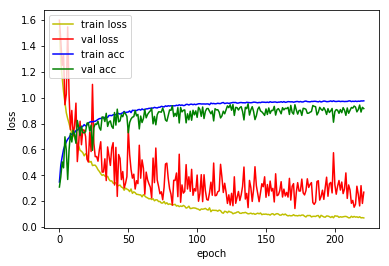

3183/3183 [==============================] - 3s 988us/sample - loss: 0.3208 - acc: 0.8882
Loss: 0.3208058054927307 Accuracy: 0.8881558



In [13]:
for i in range(5, 8):
    base = 'vis_imagenet_6_class_2D_CNN_custom_ch_32_DO_050_DO'
    model_name = base+'_{}_conv'.format(i)
    
#     with tf.device('/cpu:0'):
    model = build_2d_cnn_custom_ch_32_DO(conv_num=i)
#     model = multi_gpu_model(model, gpus=2)
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit_generator(data_generator,
            steps_per_epoch=len(x_train)//batch_size,
            epochs=10000,
            validation_data=(x_val, y_val),
            callbacks = [checkpointer, early_stopping],
            workers=8, 
            use_multiprocessing=True
    )
    
    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test, y_test)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [9]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = 'vis_imagenet_6_class_2D_CNN_custom_ch_32_DO_050_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 8):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test, y_test)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


vis_imagenet_6_class_2D_CNN_custom_ch_32_DO_050_DO_3_conv Model
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 172, 172, 3)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 172, 172, 32)      2432      
_________________________________________________________________
activation_28 (Activation)   (None, 172, 172, 32)      0         
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 86, 86, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 86, 

3183/3183 [==============================] - 2s 762us/sample - loss: 0.4856 - acc: 0.8014
Loss: 0.48557202282975837 Accuracy: 0.8014452

vis_imagenet_6_class_2D_CNN_custom_ch_32_DO_050_DO_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 172, 172, 3)       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 172, 172, 32)      2432      
_________________________________________________________________
activation_33 (Activation)   (None, 172, 172, 32)      0         
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 86, 86, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 86, 86, 32)        25632     
_________________________________________________________________
activat

In [10]:
for i in range(3, 8):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test, y_test)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


vis_imagenet_6_class_2D_CNN_custom_ch_32_DO_050_DO_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 172, 172, 3)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 172, 172, 32)      2432      
_________________________________________________________________
activation_28 (Activation)   (None, 172, 172, 32)      0         
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 86, 86, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 86, 86, 32)        25632     
_________________________________________________________________
activation_29 (Activation)   (None, 86, 86, 32)        0         
_________________________________________________________________
max_pooling

3183/3183 [==============================] - 3s 839us/sample - loss: 0.2244 - acc: 0.9211
Loss: 0.22444919844374805 Accuracy: 0.9211436

vis_imagenet_6_class_2D_CNN_custom_ch_32_DO_050_DO_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 172, 172, 3)       0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 172, 172, 32)      2432      
_________________________________________________________________
activation_39 (Activation)   (None, 172, 172, 32)      0         
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 86, 86, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 86, 86, 32)        25632     
_________________________________________________________________
activat

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [11]:
i = 6
model_name = base+'_{}_conv'.format(i)
print()
print(model_name, 'Model')
model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
# model_filename = model_path + sorted(os.listdir(model_path))[-1]
model_filename = model_path + '000_last.hdf5'


model = load_model(model_filename)
model.summary()

[loss, accuracy] = model.evaluate(x_test, y_test)
print('Loss:', loss, 'Accuracy:', accuracy)


vis_imagenet_6_class_2D_CNN_custom_ch_32_DO_050_DO_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 172, 172, 3)       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 172, 172, 32)      2432      
_________________________________________________________________
activation_33 (Activation)   (None, 172, 172, 32)      0         
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 86, 86, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 86, 86, 32)        25632     
_________________________________________________________________
activation_34 (Activation)   (None, 86, 86, 32)        0         
_________________________________________________________________
max_pooling

Confusion Matrix
[[  28    0    1    1    0    0]
 [   5  932   12   85    2   14]
 [   0    3   62   13    0    0]
 [   4   29   75 1831    0    1]
 [   0    0    0    1   32    1]
 [   0    1    0    1    2   47]]

Classification Report
              precision    recall  f1-score   support

         bed       0.76      0.93      0.84        30
        bird       0.97      0.89      0.93      1050
         cat       0.41      0.79      0.54        78
         dog       0.95      0.94      0.95      1940
       house       0.89      0.94      0.91        34
        tree       0.75      0.92      0.82        51

   micro avg       0.92      0.92      0.92      3183
   macro avg       0.79      0.90      0.83      3183
weighted avg       0.93      0.92      0.93      3183




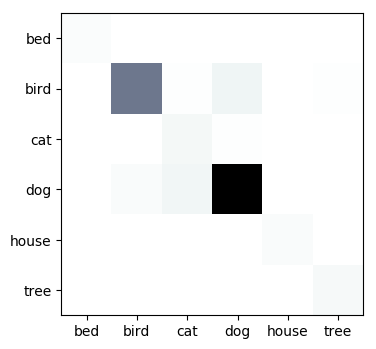

In [13]:
Y_pred = model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)
y_real = np.argmax(y_test, axis=1)
confusion_mat = confusion_matrix(y_real, y_pred)
print('Confusion Matrix')
print(confusion_mat)
print()

print('Classification Report')
print(classification_report(y_real, y_pred, target_names=y_list))
print()

# labels = y_table.T[0]
plt.figure(figsize=(4,4), dpi=100)
plt.xticks(np.arange(len(y_list)), y_list)
plt.yticks(np.arange(len(y_list)), y_list)
plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.bone_r)